## Need-To-Do

- Analyze how much of a difference recoded transfers make?
- Properly characterize missingness based on dropped discharge dates
- Properly characterize amount of data loss with each cohort change
- ~~Remove patients with no demographic information -- detectable by a null age~~

Shape of final table:

| ruid | visit_id | admit_date | discharge_date | hospital_day | n_transfers | stay_length | readmit_time | readmit_30d |
|------|----------|------------|----------------|--------------|-------------|-------------|--------------|-------------|
| user id | hospital stay # | date admitted | date discharged | date in hospital | number of transfers | duration of stay | time from last discharge to this admission | was the patient a 30d readmit? |


## Nice-To-Do

- Construct missing discharge/admit dates from CPT codes -- do not do this for events where both are missing as these may be ER visits w/o admit, but do check if they fall in the range of an existing stay
- Characterize the amount of missingness of entire hospital visits from CPT codes

## Loading data

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
adt = pd.read_table('../data/FONNESBECK_ADT_20151202.csv', encoding='latin1', sep = ',', 
                    infer_datetime_format=True, parse_dates=['Admission_date','Event_Date','DISCHARGE_DATE'],
                    dtype={'RUID':np.str})
pheno = pd.read_table('../data/FONNESBECK_phenotype_20151202.csv', encoding='latin1', sep = ',',
                    infer_datetime_format=True, parse_dates=['DOB','DOD'],
                    dtype={'RUID':np.str})
cpt = pd.read_table('../data/FONNESBECK_CPT_20151202.csv', encoding='latin1', sep = ',',
                    infer_datetime_format=True, parse_dates=['Event_date'],
                   dtype={'RUID':np.str})

In [3]:
svc = pd.read_excel('../data/FONNESBECK_DD_2014102014.xlsx',sheet_name='Service code', sep = ',', header=0, names=['SVC','Desc'])

In [4]:
adt.Event = pd.Categorical(adt.Event,categories = ['Admit','Transfer','Discharge'])
adt = adt.sort_values(by = ['RUID','Admission_date','Event','Event_Date']).reset_index(drop = True)

## Adding ages and filtering out pediatric & psych patients

In [5]:
# calculate age of patient when an event occurs
adt_age = pd.merge(adt,pheno)
events = adt_age.Event_Date.dt
birthdays = adt_age.DOB.dt

adt_age['age'] = events.year - birthdays.year + ((events.month < birthdays.month) & (events.day < birthdays.day))
# above from https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python/9754466#9754466

In [6]:
# getting rid of peds & psychiatric patients...
# we're removing these because they aren't part of the CMS criteria so 30-day readmits for them don't lose the hospital money
ped_svc = '|'.join(svc.SVC[svc.Desc.str.contains("CHILD|PED")])
psych_svc = '|'.join(svc.SVC[svc.Desc.str.contains("PSYCH")])

ped_filter = (adt_age.age < 18)
# removing all rows where the patient would be classified as a pediatric patient;
# we also experimented with removing all rows with a pediatric service code, but this is more straightforward
# it does not however account for older patients getting services through the pediatric hospital, e.g.
# 20-year-olds getting follow-up for pediatric cancers

psych_filter = (adt_age.SRV_CODE.str.contains(psych_svc) & (adt_age.Event == "Admit"))
# explicitly remove psychiatric admits but not psych consults during admits for other reasons;
# because we're only working with admit dates as records of patient visits later, this means we effectively remove any visits where the patient
# was a primary admit to psychiatric services

In [7]:
adt_cms = adt[~(ped_filter | psych_filter | adt_age.age.isnull())].copy()

## Filtering to admits & eliminating missing discharges

In [8]:
adt_cms['imputed_transfer'] = [0]*adt_cms.shape[0] # create a new column to store flag

txmask = (adt_cms.Event == "Admit") & (adt_cms.Admission_date != adt_cms.Event_Date)
# there are 431 of these that we suspect are transfers, not admits
# because they're labeled "admit" but happen after the listed admit date for the visit

adt_cms.loc[txmask,'Event'] = "Transfer"
adt_cms.loc[txmask,'imputed_transfer'] = 1

In [9]:
adt_cms_admits = adt_cms[(adt_cms.Event == 'Admit') & ~(adt_cms.DISCHARGE_DATE.isnull())].copy().reset_index(drop = True)

# remove everything where we're missing a discharge date

## Constructing variables

In [10]:
adt_cms_admits['stay_length'] = adt_cms_admits.DISCHARGE_DATE - adt_cms_admits.Admission_date
adt_cms_admits['readmit_time'] = adt_cms_admits.Admission_date.shift(-1) - adt_cms_admits.DISCHARGE_DATE

didx = ~(adt_cms_admits.RUID.shift(-1) == adt_cms_admits.RUID)

adt_cms_admits['readmit_time'] = adt_cms_admits['readmit_time'].mask(didx)

adt_cms_admits['readmit_30d'] = np.where(adt_cms_admits.readmit_time <= datetime.timedelta(days=30),1,0)
adt_cms_admits = adt_cms_admits[~(adt_cms_admits.readmit_time < datetime.timedelta(days=0))] # get rid of double admits where we had a different
# chief complaint or svc code

In [11]:
event_counts = (adt_cms[~(adt_cms.DISCHARGE_DATE.isnull())].groupby(by=['RUID','Admission_date'])
                .Event
                .value_counts(sort=False)
                .unstack(fill_value = 0))

n_transfers = event_counts['Transfer'] # now pull the number of transfers and we're good
# merge this by multindex onto the other table once it's cleaned & ready to go

In [12]:
adt_cms_admits2 = (adt_cms_admits.drop(labels=['Event','Event_Date','SRV_CODE','imputed_transfer','CHIEF_COMPLAINT'], axis = 1)
                  .set_index(['RUID','Admission_date'])
                  .join(n_transfers)
                  .reset_index(drop = False)
                  .rename({'RUID': 'ruid', 'Admission_date': 'admit_date', 'DISCHARGE_DATE': 'discharge_date', 'Transfer': 'n_transfers'},axis = 1))

In [13]:
adt_cms_admits2['visit_id'] = adt_cms_admits2.groupby('ruid').cumcount()

In [14]:
def date_ranger(x):
    start = x.iloc[0]['admit_date']
    end = x.iloc[0]['discharge_date']
    return pd.DataFrame(pd.date_range(start=start, end=end).tolist())

In [15]:
hospital_day = (adt_cms_admits2.groupby(['ruid','visit_id'])
                .apply(date_ranger)
                .reset_index(drop = False)
                .drop('level_2',axis = 1)
                .set_index(['ruid','visit_id']))

# takes a bit to run

In [16]:
adt_cms_final = (adt_cms_admits2.set_index(['ruid','visit_id'])
                .join(hospital_day)
                .reset_index(drop = False)
                .rename({0:'hospital_day'},axis=1))[['ruid','visit_id','admit_date','discharge_date','hospital_day',
                                                     'stay_length','n_transfers','readmit_time','readmit_30d']]

In [17]:
adt_cms_final

,ruid,visit_id,admit_date,discharge_date,hospital_day,stay_length,n_transfers,readmit_time,readmit_30d
0,50135262,0,2007-02-08,2007-02-12,2007-02-08,4 days,2,172 days,0
1,50135262,0,2007-02-08,2007-02-12,2007-02-09,4 days,2,172 days,0
2,50135262,0,2007-02-08,2007-02-12,2007-02-10,4 days,2,172 days,0
3,50135262,0,2007-02-08,2007-02-12,2007-02-11,4 days,2,172 days,0
4,50135262,0,2007-02-08,2007-02-12,2007-02-12,4 days,2,172 days,0
5,50135262,1,2007-08-03,2007-08-06,2007-08-03,3 days,3,22 days,1
6,50135262,1,2007-08-03,2007-08-06,2007-08-04,3 days,3,22 days,1
7,50135262,1,2007-08-03,2007-08-06,2007-08-05,3 days,3,22 days,1
8,50135262,1,2007-08-03,2007-08-06,2007-08-06,3 days,3,22 days,1
9,50135262,2,2007-08-28,2007-08-29,2007-08-28,1 days,1,179 days,0


In [18]:
final_ruids = adt_cms_final.ruid.unique()

In [19]:
len(final_ruids)
# from 8000 patients, we're down to ~~5664~~ 5623 after eliminating everyone with no demographic info,
# all the pediatric patients, and all the psych admits.

5623

In [20]:
adt_cms_final.to_pickle("../data/adt_cms_final.pkl")

In [27]:
n_visits = adt_cms_admits2.groupby('ruid').visit_id.max()+1

In [29]:
n_30d = adt_cms_admits2.groupby('ruid').readmit_30d.sum()

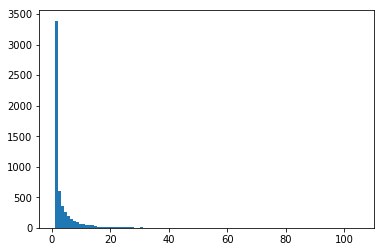

In [32]:
import matplotlib.pyplot as plt

plt.hist(n_visits, bins = 100);

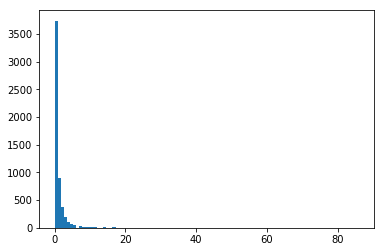

In [33]:
plt.hist(n_30d, bins = 100);

In [34]:
n_30d.describe()

count    5623.000000
mean        1.006936
std         3.207868
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        86.000000
Name: readmit_30d, dtype: float64

In [35]:
n_visits.describe()

count    5623.000000
mean        3.741953
std         5.657775
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       105.000000
Name: visit_id, dtype: float64

In [36]:
n_30d[n_30d > 0].describe()

count    1884.000000
mean        3.005308
std         4.971397
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        86.000000
Name: readmit_30d, dtype: float64

In [37]:
n_30d[(n_30d > 0) & (n_30d < 86)].describe()

count    1883.000000
mean        2.961232
std         4.589769
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        78.000000
Name: readmit_30d, dtype: float64

In [41]:
n_30d[n_30d > 10]

ruid
50135437    25
50141085    13
53719335    17
53728001    74
53728030    13
53728157    14
53728262    17
53728343    20
53728400    11
53728578    24
53728652    11
53728778    26
53728993    12
53729067    14
53729068    15
53729313    25
53729331    17
53729469    16
53729476    20
53729571    11
53729615    34
53729810    11
53729816    11
53729822    31
53729860    14
53729979    11
53730030    14
53730096    22
53730141    78
53730619    11
            ..
53732608    12
53732626    19
53732727    11
53732869    17
53733061    23
53733205    19
53733326    18
53733351    40
53733384    16
53733505    17
53733747    38
53733810    13
53733876    11
53733909    11
53734271    29
53734307    50
53734366    11
53734416    12
53734444    17
53734565    19
53734944    50
53734959    11
53735136    21
53735141    12
53735152    11
53735526    14
53735988    11
53736045    19
53736112    13
53736286    86
Name: readmit_30d, Length: 73, dtype: int64